In [1]:
# prepare 
import numpy as np
import pylab as pb
import GPy as gpy
import matplotlib
from matplotlib import pyplot as plt
from numpy.linalg import inv
from IPython.display import display
from scipy.fftpack import fft, ifft
pb.ion()
%matplotlib inline  
%config InlineBackend.figure_format = 'svg'
matplotlib.rcParams['figure.figsize'] = (8,5)

C:\Users\Ruoxi\Anaconda\lib\site-packages\GPy\util\linalg.py:48: UserWarning: warning: caught this exception:function 'dsyrk_' not found
  warnings.warn("warning: caught this exception:" + str(e))


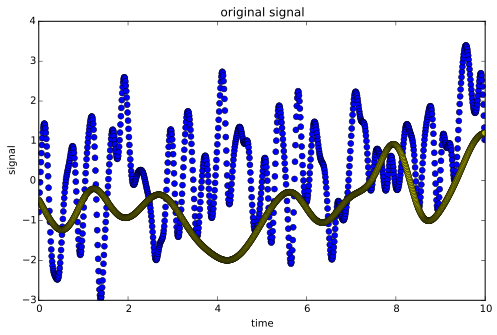

In [65]:
# generate two random signals

fs = 100.0  #  time step:1/fs
 

t = np.arange(0,10,1/fs)[np.newaxis].transpose()
num_points = t.size

# signal 1
k1 = gpy.kern.RBF(1, variance=2, lengthscale=0.1)
# add a small number to the diagonal to avoid issues due to floating point number (machine precision) 
x1 = np.random.multivariate_normal(np.zeros(num_points), k1.K(t)+ np.identity(t.size)*1E-10)

# signal 2
k2 = gpy.kern.RBF(1, variance=1, lengthscale=0.5)
x2 = np.random.multivariate_normal(np.zeros(num_points), k2.K(t)+ np.identity(t.size)*1E-10)


# plot two signals 
x = np.vstack([x1,x2])
plt.plot(t.flatten(), x[0,], 'bo')
plt.plot(t.flatten(), x[1,], 'yo')
plt.xlabel('time');plt.ylabel('signal');plt.title('original signal')


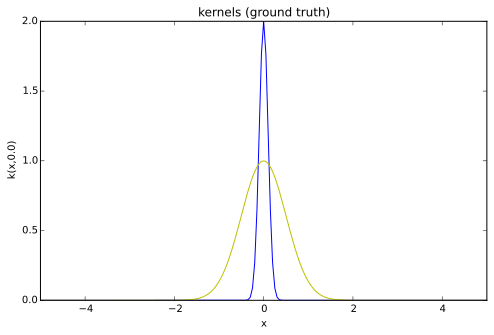

In [66]:
# plot kernel (before transformation)
k1.plot(color = 'b',ax=plt.gca())
_ = k2.plot(color = 'y',ax=plt.gca()) 
plt.xlabel('x') ;plt.title('kernels (ground truth)')


In [67]:
# covariance of original signals
sigma0 = np.cov(x)
sigma0

array([[ 1.53927318,  0.17635034],
       [ 0.17635034,  0.51319146]])

In [68]:
# antidiagonal of sigma0 is rho
rho = sigma0[0,1]
rho

0.17635034137465139

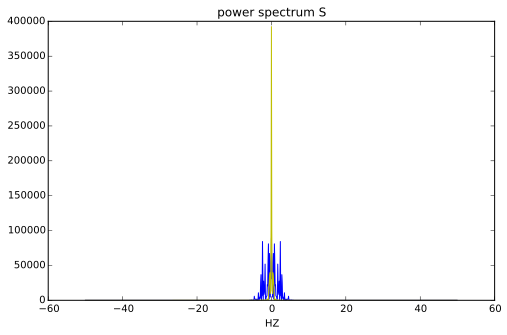

In [69]:
# fourier transform of signal 
xF1 = np.fft.fft(x1)
xF2 = np.fft.fft(x2)

# power spectrum S
# or S = np.conjugate(xF) * xF
S1 = abs(xF1)**2
S2 = abs(xF2)**2
freqs = np.fft.fftfreq(t.size, 1/fs)
idx = np.argsort(freqs)

# plot power spectrum 
plt.plot(freqs[idx], S1[idx])  
plt.title("power spectrum S")
plt.xlabel('HZ')

plt.plot(freqs[idx], S2[idx],'y') 
plt.title("power spectrum S")
plt.xlabel('HZ')

In [73]:
# autocorrelation 
# Bochner's theorem (spectral density to autocorrelaion ： ifft) 
R1 = ifft(S1)
R2 = ifft(S2)

# autocovariance matrix (C) using autocorrelation. As mean is zero, C(i,j) = R(asb(i-j))
C1 = np.matrix([[R1[abs(i-j)] for i in range(R1.size)] for j in range(R1.size)])/t.size 
C2 = np.matrix([[R2[abs(i-j)] for i in range(R2.size)] for j in range(R2.size)])/t.size 
 



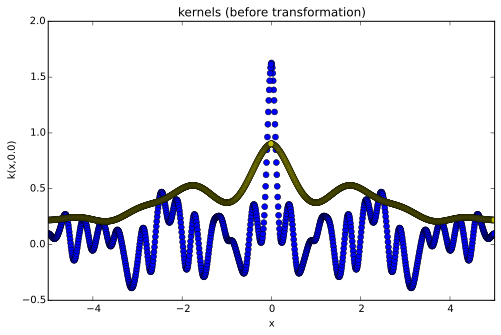

In [74]:
# plot inferred kernels before transformation 
# inferred kernels are generated using inferred covariance matrix 
# peak of blue kernel is about 2, peak of yellow kernel is about 1, as ground truth. 
# inferred kernels are not exact the same as ground truth because of randomness of generating data at the first place. 

plt.plot(t[idx]-5, np.array(C1[0,]).flatten(), 'bo')
_ = plt.plot(t[idx]-5, np.array(C2[0,]).flatten(), 'yo')

plt.xlim((-5,5))
plt.xlabel('x'); plt.ylabel('k(x,0.0)'); plt.title('kernels (before transformation)')


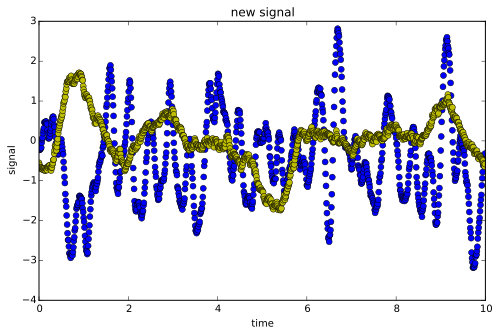

In [89]:
# one ramdom draw from GP using inferred autocovariance matrix (C) 
mu = np.zeros((R1.size)) 
z1 = np.random.multivariate_normal(mu,C1,1)
z2 = np.random.multivariate_normal(mu,C2,1)

z = np.vstack([z1,z2])
plt.plot(t.flatten(), z[0,], 'bo')
plt.plot(t.flatten(), z[1,], 'yo')
plt.xlabel('time');plt.ylabel('signal');plt.title('new signal')

In [90]:
# covariance
sigma1 = np.cov(z)
sigma1.real

array([[ 1.27125593, -0.10985255],
       [-0.10985255,  0.41248207]])

In [91]:
# draw 10000 times from signal 1 and signal 2
# covariance is maximum liklihood estimator (average） 

zz1 = np.random.multivariate_normal(mu,C1,10000)
zz2 = np.random.multivariate_normal(mu,C2,10000)

sigma_sum = 0
for i in xrange(1, 10000):
    zz = np.vstack([zz1[i,],zz2[i,]])
    sigma_sum = sigma_sum + np.cov(zz)

sigma1 = sigma_sum/10000 

# we expect antidiagonal of sigmal1 to be close to zero
sigma1.real

array([[  1.53829468e+00,  -1.00075053e-03],
       [ -1.00075053e-03,   5.11041199e-01]])

In [92]:
# from sigma1 to sigma0 
# Cholesky factorization 
# goal: to infer L such that sigma0 = L* sigma1* L.H
# sigma1 = L1*I*L1.H 
# I = inverse(L1) *sigma1* inverse(L1.H)
# sigma0 = L0*I*L0.H 
# sigma0 = L0*inverse(L1) *sigma1* inverse(L1.H)*L0.H
#        = [L0*inverse(L1)] *sigma1* [L0*inverse(L1)].H
# Thus, L = L0*inverse(L1)

L1 = np.linalg.cholesky(sigma1)
L0 = np.linalg.cholesky(sigma0)
L = np.dot(L0, inv(L1)) 

# verify sigma0 = L* sigma1* L.H
print np.dot(np.dot(L, sigma1),L.T.conj()).real
print sigma0.real


[[ 1.53927318  0.17635034]
 [ 0.17635034  0.51319146]]
[[ 1.53927318  0.17635034]
 [ 0.17635034  0.51319146]]


In [94]:
## transform signal draw 

# covariance
z_transformed = np.dot(L,z)
sigma2 = np.cov(z_transformed)
# may have variations from we expect (sigma0), as only single draw
print sigma2.real



[[ 1.27206456  0.03862043]
 [ 0.03862043  0.38992592]]


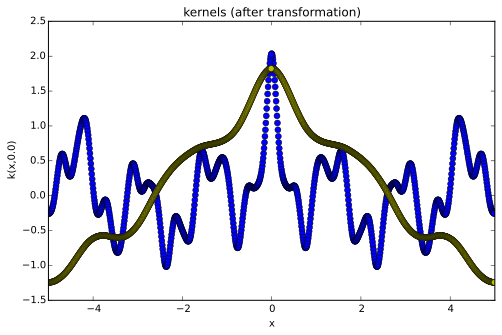

In [96]:
# plot after transformed kernels

# power spectrum (a combination of s1 and s2)
zF1 = np.fft.fft(z_transformed[0,])
zF2 = np.fft.fft(z_transformed[1,])
zS1 = abs(zF1)**2
zS2 = abs(zF2)**2 

zR1 = ifft(zS1)
zR2 = ifft(zS2)

# autocovariance matrix (C) using autocorrelation. As mean is zero, C(i,j) = R(asb(i-j))
zC1 = np.matrix([[zR1[abs(i-j)] for i in range(zR1.size)] for j in range(zR1.size)])/t.size
zC2 = np.matrix([[zR2[abs(i-j)] for i in range(zR2.size)] for j in range(zR2.size)])/t.size

#plot kernels after transfomation, which should be deviated from ground truth
plt.plot(t[idx]-5, np.array(zC1[0,]).flatten(), 'bo')
_ = plt.plot(t[idx]-5, np.array(zC2[0,]).flatten(), 'yo')
plt.xlim((-5,5))
plt.xlabel('x'); plt.ylabel('k(x,0.0)'); plt.title('kernels (after transformation)')

In [95]:
# transform 10000 draws and take average (approximately expected value)
sigma_sum = 0
for i in xrange(1, 10000):
    zz = np.vstack([zz1[i,],zz2[i,]])
    zz_transformed = np.dot(L,zz)
    sigma_sum = sigma_sum + np.cov( zz_transformed)

sigma2 = sigma_sum/10000 

# expect sigma2 can recover sigma0 (confirmed recovered covariance)
print sigma2.real
print sigma0.real

[[ 1.53927318  0.17635034]
 [ 0.17635034  0.51319146]]
[[ 1.53927318  0.17635034]
 [ 0.17635034  0.51319146]]
